In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns
import os
from scipy.optimize import curve_fit

In [2]:
sns.set_context('talk')

In [3]:
LIF_resultDir = 'LIF_output'

if not os.path.exists(LIF_resultDir):
    os.makedirs(LIF_resultDir)

In [4]:
El = -60
Cm = 0.1
vreset = -80

gl_min = 0.05
gl_max = 0.2

Iapp_min = -50
Iapp_max = 100
Iapp_step = 0.5

Emi = 10

vth = -40
nVals = int(2000)

gMI_vals = [0, 0.20, 0.36]


In [5]:
def vss_mi(Iapp,El,gl,Emi,gmi):
    vssVals = (Iapp + gl*El + gmi*Emi)/(gl+gmi)
    return vssVals

def fFxn(Cm,Iapp,vreset,vth,El,gl,Emi,gmi):
    vssVals = vss_mi(Iapp,El,gl,Emi,gmi)
    tau = Cm / (gl+gmi)
    invalidIdx = vssVals  < vth
    fVal = 1 / ( tau * np.log( (vssVals-vreset) / (vssVals-vth) ) )
    fVal[invalidIdx] = 0
    return fVal

def analyticalI0(vth,gl,gmi,El,Emi):
    I0 = vth*(gl+gmi)- (gl*El) - (gmi*Emi)
    return I0
def ac_powerFxn(x,a,b,I0):
    freq = a*(x-I0)**b
    freq[np.isnan(freq)]= 0
    return freq



In [6]:

def neuronSimulator_leak(params):
    f_leak = fFxn(Cm = Cm,Iapp=Iapp,vreset = vreset,vth = params[0],
                  Tref= params[1],El= El,
                  gl= params[2],Emi = 0, gmi = 0)
    
    return np.concatenate([f_leak])*1000

def neuronSimulator_mod(params):

    f_mod = fFxn(Cm = Cm,Iapp=Iapp,vreset = vreset,vth = params[0],
                  Tref= params[1],El= El,
                  gl= params[2],Emi = 10, gmi = params[3])
    
    return np.concatenate([f_mod])*1000

In [7]:
import matplotlib.colors as colors
cmap = colors.LinearSegmentedColormap.from_list("", ["black",'blue'])

cMapping = np.linspace(0.2,0.8,len(gMI_vals))
cMapping

array([0.2, 0.5, 0.8])

In [8]:
newSampleBool = False
if newSampleBool == True:
    uniform_gleak = np.abs(np.random.uniform(gl_min,gl_max,nVals))

else:
    uniform_gleak = pd.read_csv('lifData/gl_vals.csv')
    uniform_gleak = np.array(uniform_gleak['uniform'])

In [9]:
%%time

IappVect = np.atleast_2d(np.linspace(Iapp_min,Iapp_max,int(Iapp_max/Iapp_step)))

glValsDf = pd.DataFrame({'uniform':uniform_gleak,
                        })

vssList = []
fi_returnList = []
I0_list = []

for colIdx,colName in enumerate(glValsDf):
    glVals = np.atleast_2d(glValsDf[colName]).T
    for gmi in gMI_vals:
        fi_returnList.append(fFxn(Cm,IappVect,vreset,vth,El,glVals,Emi,gmi))
        I0_list.append(analyticalI0(vth,glVals,gmi,El,Emi))


CPU times: user 50.4 ms, sys: 8.94 ms, total: 59.4 ms
Wall time: 57.9 ms


/tmp/ipykernel_44887/793828820.py:9: RuntimeWarning: invalid value encountered in log
  fVal = 1 / ( tau * np.log( (vssVals-vreset) / (vssVals-vth) ) )


<timed exec>:11: RuntimeWarning: invalid value encountered in true_divide
<timed exec>:11: RuntimeWarning: invalid value encountered in true_divide
<timed exec>:11: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 5.15 s, sys: 325 ms, total: 5.47 s
Wall time: 4.87 s


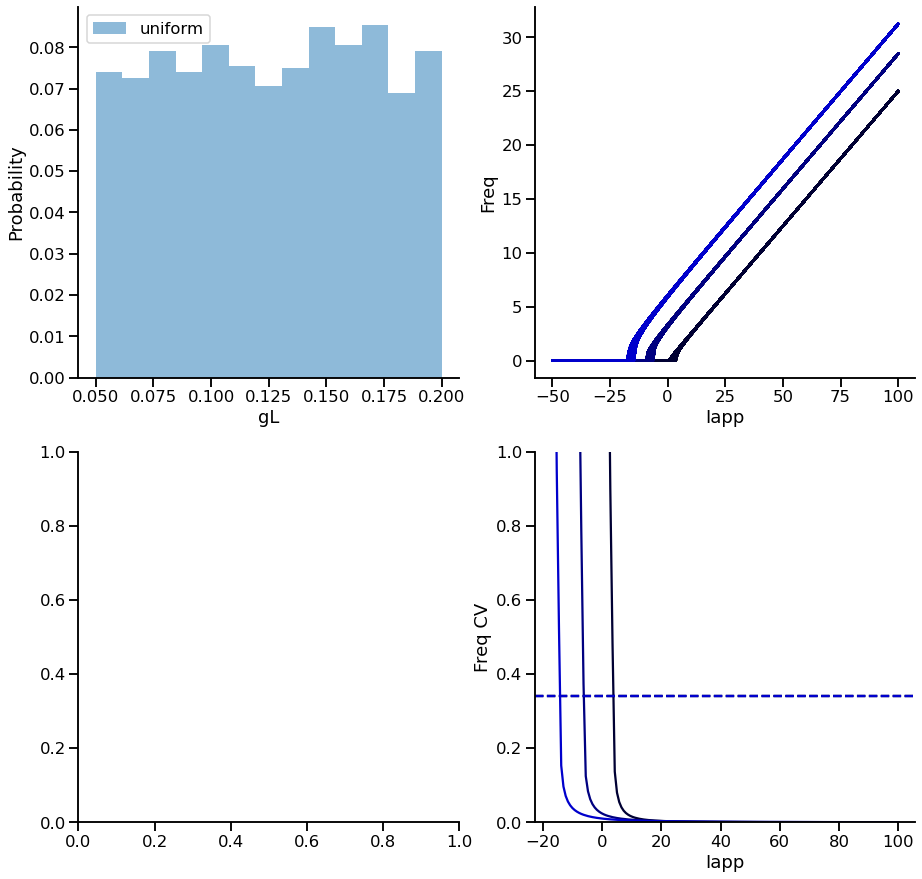

In [10]:
%%time
colorList = ['black','blue','magenta']


statsFig, statsAxes = plt.subplots(2,2, figsize=(15,15) )


sns.histplot(ax = statsAxes[0,0], data=glValsDf, stat='probability', edgecolor=None)


for fiIdx,fiList in enumerate(fi_returnList):
    fi_CV = np.std(fi_returnList[fiIdx].T, axis =1 )/np.mean(fi_returnList[fiIdx].T, axis =1 ) 
    gl_CV = np.std(glValsDf[colName])/np.mean(glValsDf[colName])
    statsAxes[1,1].plot(IappVect[0],fi_CV, color=cmap(cMapping[fiIdx]))
    statsAxes[1,1].axhline(y = gl_CV, color=cmap(cMapping[fiIdx]), linestyle = '--')

    
    for fiLine in fiList:
        statsAxes[0,1].plot(IappVect[0],fiLine,color=cmap(cMapping[fiIdx]))
        
statsAxes[0,0].set_xlabel('gL')


statsAxes[0,1].set_ylabel('Freq')
statsAxes[0,1].set_xlabel('Iapp')

statsAxes[1,1].set_ylabel('Freq CV')
statsAxes[1,1].set_xlabel('Iapp')

statsAxes[1,1].set_ylim([0,1])
sns.despine()

In [11]:
statsFig.savefig(LIF_resultDir+'/uniform_gl_FIs_cv.pdf')

In [12]:
%%time

fitBounds = [(None,None),(None,None)]


Iapp =IappVect[0]
all_gmi_fits = []
for gmiIdx,fiList in enumerate(fi_returnList):
    gmi_powerFitsList = []
    
   
    for fiIdx,fiVals in enumerate(fiList):
        I0Val = I0_list[gmiIdx][fiIdx]
    
    
        def ac_powerFxn_analyticalI0(x,a,b):
            freq = a*(x-I0Val)**b
            freq[np.isnan(freq)]= 0
            return freq
        try:
            powerFitParams, powerFitCoVar = curve_fit(ac_powerFxn_analyticalI0, Iapp, np.array(fiVals),bounds=fitBounds)
            
        except (RuntimeError):
            try:
                p0 = [max(fiVals), 0.5]
                
                powerFitParams, powerFitCoVar = curve_fit(ac_powerFxn_analyticalI0, Iapp, np.array(fiVals),p0,bounds=fitBounds)
                

            except(RuntimeError, ValueError):
                powerFitParams = np.array([np.nan]*2)

        gmi_powerFitsList.append(powerFitParams)
    all_gmi_fits.append(gmi_powerFitsList)

<timed exec>:15: RuntimeWarning: invalid value encountered in power


CPU times: user 20.7 s, sys: 24.2 ms, total: 20.7 s
Wall time: 20.7 s


In [13]:
concactDf = pd.DataFrame(columns = ['a','b','I0','gmi'])

for fitIdx,fitList in enumerate(all_gmi_fits):
    tempDF = pd.DataFrame(fitList,columns=['a','b'])
    tempDF['I0'] = I0_list[fitIdx]
    tempDF['gmi'] = gMI_vals[fitIdx]
    concactDf = pd.concat([concactDf, tempDF] ,ignore_index=True)

gmi_powerFitsDf =  concactDf

CPU times: user 410 ms, sys: 124 ms, total: 534 ms
Wall time: 332 ms


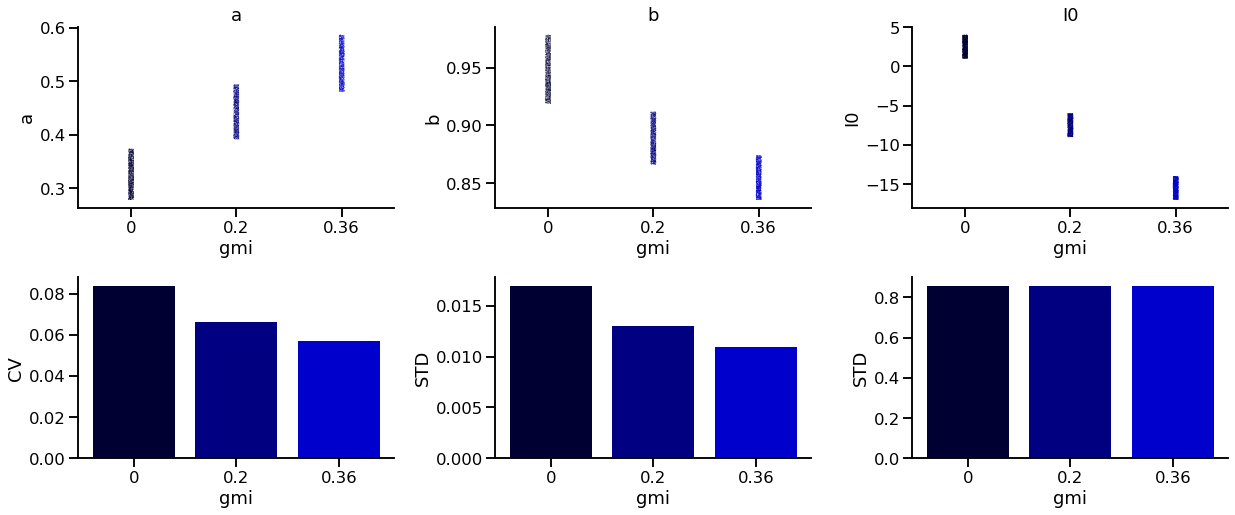

In [14]:
%%time

gmiFitsFig,gmiFitsAxes = plt.subplots(2,3, figsize=(17.5,7.5))

sns.stripplot(x='gmi',y='a',data=gmi_powerFitsDf, 
              ax = gmiFitsAxes[0,0], palette = sns.color_palette(cmap(cMapping)), size = 0.5, jitter = 0.025)
sns.stripplot(x='gmi',y='b',data=gmi_powerFitsDf, 
              ax = gmiFitsAxes[0,1], palette = sns.color_palette(cmap(cMapping)), size = 0.5, jitter = 0.025)
sns.stripplot(x='gmi',y='I0',data=gmi_powerFitsDf, 
              ax = gmiFitsAxes[0,2], palette = sns.color_palette(cmap(cMapping)), size = 0.5, jitter = 0.025)


for gmiIdx,gmiVal in enumerate(gMI_vals):
    c =cmap(cMapping[gmiIdx])
    
    a_vals = gmi_powerFitsDf.a[gmi_powerFitsDf.gmi==gmiVal]
    b_vals = gmi_powerFitsDf.b[gmi_powerFitsDf.gmi==gmiVal]
    I0_vals = gmi_powerFitsDf.I0[gmi_powerFitsDf.gmi==gmiVal]
    
    
    
    
    gmiFitsAxes[1,0].bar(x = gmiIdx, 
                       height = np.std(a_vals)/np.mean(a_vals), color = c)
    gmiFitsAxes[1,1].bar(x = gmiIdx, 
                   height = np.std(b_vals), color = c)
    gmiFitsAxes[1,2].bar(x = gmiIdx, 
               height = np.std(I0_vals), color = c)
    
gmiFitsAxes[0,0].set_title('a')    
gmiFitsAxes[0,1].set_title('b')    
gmiFitsAxes[0,2].set_title('I0') 

gmiFitsAxes[1,0].set_ylabel('CV')    
gmiFitsAxes[1,1].set_ylabel('STD')    
gmiFitsAxes[1,2].set_ylabel('STD')    

gmiFitsAxes[1,0].set_xlabel('gmi')    
gmiFitsAxes[1,1].set_xlabel('gmi')    
gmiFitsAxes[1,2].set_xlabel('gmi')    



    
    
for rowIdx,rowAxes in enumerate(gmiFitsAxes):
    for colIdx, colAxes in enumerate(rowAxes):
        gmiFitsAxes[rowIdx,colIdx].set_xticks(np.arange(0,len(gMI_vals)))
        gmiFitsAxes[rowIdx,colIdx].set_xticklabels([str(np.round(x,2))for index, x in enumerate(gMI_vals)])    
sns.despine()
plt.tight_layout()

In [15]:
gmiFitsFig.savefig(LIF_resultDir+'/powerFunctionFitsFig.pdf')